Total Scenarios Simulated: 5000
Unblocked Lines of Sight: 4173
Probability of Visibility: 83.46%


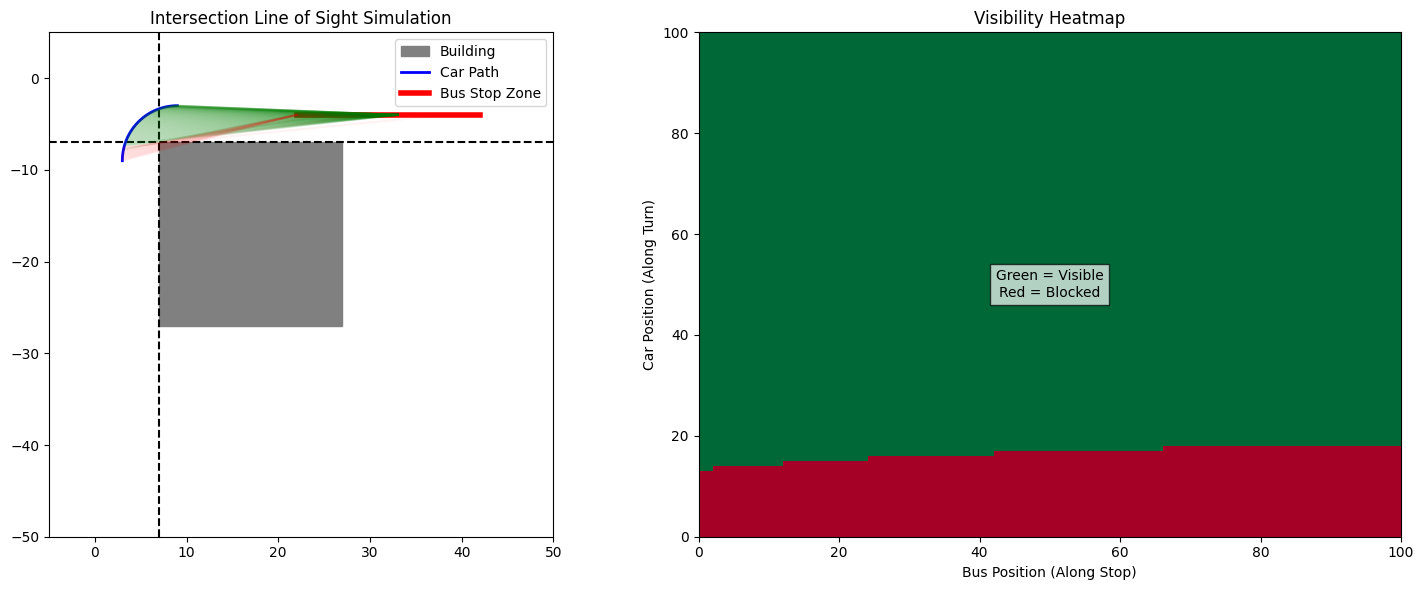

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

def simulate_intersection_visibility():
    road_width = 10
    lane_width = 4
    corner_radius = 5
    building_offset = 2

    corner_x = road_width/2 + building_offset
    corner_y = -(road_width/2 + building_offset)

    t = np.linspace(0, np.pi/2, 100)

    turn_center_x = corner_x + 2
    turn_center_y = corner_y - 2
    turn_radius = 6

    car_x_path = turn_center_x - turn_radius * np.cos(t)
    car_y_path = turn_center_y + turn_radius * np.sin(t)

    bus_stop_start_x = corner_x + 15
    bus_stop_end_x = corner_x + 35
    bus_y = -(road_width/1.5 - lane_width/1.5)

    bus_positions_x = np.linspace(bus_stop_start_x, bus_stop_end_x, 50)

    visible_pairs = []
    blocked_pairs = []

    for i, (cx, cy) in enumerate(zip(car_x_path, car_y_path)):
        for j, bx in enumerate(bus_positions_x):
            by = bus_y

            blocked = False

            if cx < corner_x and bx > corner_x:
                slope = (by - cy) / (bx - cx)
                y_at_corner_x = cy + slope * (corner_x - cx)

                if y_at_corner_x < corner_y:
                    blocked = True

            if cy < corner_y and by > corner_y:
                slope_inv = (bx - cx) / (by - cy)
                x_at_corner_y = cx + slope_inv * (corner_y - cy)
                if x_at_corner_y > corner_x:
                    blocked = True

            if blocked:
                blocked_pairs.append((i, j))
            else:
                visible_pairs.append((i, j))

    total_scenarios = len(car_x_path) * len(bus_positions_x)
    visible_count = len(visible_pairs)
    probability = (visible_count / total_scenarios) * 100

    print(f"Total Scenarios Simulated: {total_scenarios}")
    print(f"Unblocked Lines of Sight: {visible_count}")
    print(f"Probability of Visibility: {probability:.2f}%")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.set_title("Intersection Line of Sight Simulation")
    ax1.set_aspect('equal')

    building = Rectangle((corner_x, corner_y - 20), 20, 20, color='gray', label='Building')
    ax1.add_patch(building)

    ax1.axhline(corner_y, color='black', linestyle='--')
    ax1.axvline(corner_x, color='black', linestyle='--')

    ax1.plot(car_x_path, car_y_path, 'b-', linewidth=2, label='Car Path')
    ax1.plot(bus_positions_x, [bus_y]*len(bus_positions_x), 'r-', linewidth=4, label='Bus Stop Zone')

    for (i, j) in visible_pairs[::50]:
        ax1.plot([car_x_path[i], bus_positions_x[j]], [car_y_path[i], bus_y], 'g-', alpha=0.1)

    for (i, j) in blocked_pairs[::50]:
        ax1.plot([car_x_path[i], bus_positions_x[j]], [car_y_path[i], bus_y], 'r-', alpha=0.05)

    ax1.legend()
    ax1.set_xlim(-5, 50)
    ax1.set_ylim(-50, 5)

    matrix = np.zeros((len(car_x_path), len(bus_positions_x)))
    for (i, j) in visible_pairs:
        matrix[i, j] = 1

    ax2.set_title("Visibility Heatmap")
    ax2.set_xlabel("Bus Position (Along Stop)")
    ax2.set_ylabel("Car Position (Along Turn)")
    c = ax2.imshow(matrix, cmap='RdYlGn', aspect='auto', origin='lower',
                    extent=[0, 100, 0, 100])

    ax2.text(50, 50, f"Green = Visible\nRed = Blocked",
              ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    simulate_intersection_visibility()

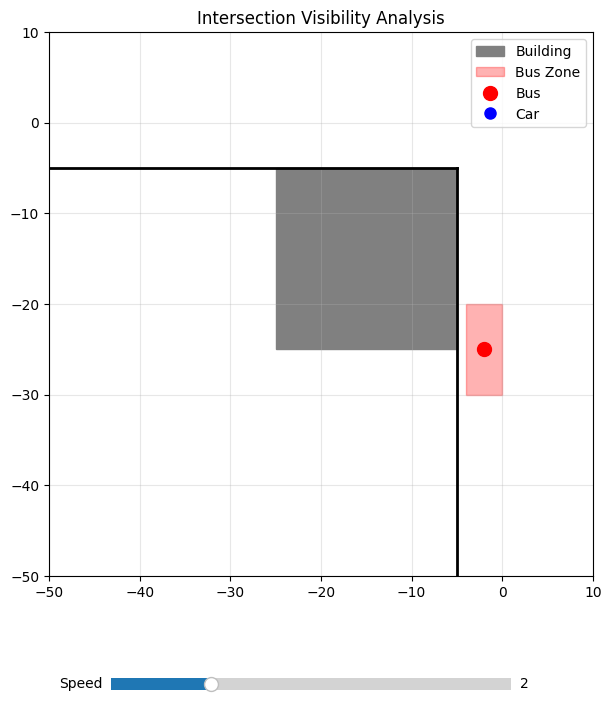

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider
from matplotlib.patches import Rectangle
from IPython.display import HTML

ROAD_WIDTH = 10
BUILDING_OFFSET = 2

BUILDING_X_MIN = -25
BUILDING_X_MAX = -5
BUILDING_Y_MIN = -25
BUILDING_Y_MAX = -5

BUS_X = -2
BUS_Y = -25

def generate_path():
    start_x = -50
    turn_start_x = -10

    path_x_straight = np.linspace(start_x, turn_start_x, 50)
    path_y_straight = np.full(50, 2)

    t = np.linspace(0, 1, 60)
    p0 = np.array([-10, 2])
    p1 = np.array([2, 2])
    p2 = np.array([2, -20])

    curve_x = (1-t)**2 * p0[0] + 2*(1-t)*t * p1[0] + t**2 * p2[0]
    curve_y = (1-t)**2 * p0[1] + 2*(1-t)*t * p1[1] + t**2 * p2[1]

    full_x = np.concatenate([path_x_straight, curve_x])
    full_y = np.concatenate([path_y_straight, curve_y])

    return full_x, full_y

path_x, path_y = generate_path()

fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(bottom=0.2)

ax.plot([-50, -5], [-5, -5], 'k-', lw=2)
ax.plot([-5, -5], [-50, -5], 'k-', lw=2)

building = Rectangle((BUILDING_X_MIN, BUILDING_Y_MIN),
                     BUILDING_X_MAX - BUILDING_X_MIN,
                     BUILDING_Y_MAX - BUILDING_Y_MIN,
                     color='gray', label='Building')
ax.add_patch(building)

bus_patch = Rectangle((-4, -30), 4, 10, color='red', alpha=0.3, label='Bus Zone')
ax.add_patch(bus_patch)

bus_dot, = ax.plot(BUS_X, BUS_Y, 'ro', markersize=10, label='Bus')

car_dot, = ax.plot([], [], 'bo', markersize=8, label='Car')

los_line, = ax.plot([], [], 'g--', lw=1)

status_text = ax.text(-60, 18, "", fontsize=12, fontweight='bold')
speed_text = ax.text(-30, 7, "", fontsize=10)

ax.set_xlim(-50, 10)
ax.set_ylim(-50, 10)
ax.set_aspect('equal')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_title("Intersection Visibility Analysis")

def is_visible(cx, cy, bx, by):
    if (cy > BUILDING_Y_MAX > by) or (cy < BUILDING_Y_MAX < by):
        x_at_top = cx + (bx - cx) * (BUILDING_Y_MAX - cy) / (by - cy)

        if BUILDING_X_MIN <= x_at_top <= BUILDING_X_MAX:
            return False

    if (cx > BUILDING_X_MAX > bx) or (cx < BUILDING_X_MAX < bx):
        y_at_right = cy + (by - cy) * (BUILDING_X_MAX - cx) / (bx - cx)

        if BUILDING_Y_MIN <= y_at_right <= BUILDING_Y_MAX:
            return False

    return True

ax_speed = plt.axes([0.25, 0.05, 0.5, 0.03])
s_speed = Slider(ax_speed, 'Speed', 1, 5, valinit=2, valstep=1)

def update(frame):
    speed = int(s_speed.val)
    idx = (frame * speed) % len(path_x)

    cx, cy = path_x[idx], path_y[idx]

    car_dot.set_data([cx], [cy])
    los_line.set_data([cx, BUS_X], [cy, BUS_Y])

    visible = is_visible(cx, cy, BUS_X, BUS_Y)

    if visible:
        los_line.set_color('#00FF00')
        los_line.set_alpha(1.0)
        status_text.set_text("Status: VISIBLE")
        status_text.set_color('green')
    else:
        los_line.set_color('red')
        los_line.set_alpha(0.5)
        status_text.set_text("Status: BLOCKED")
        status_text.set_color('red')

    speed_text.set_text(f"Simulation Speed: {speed}x")

    return car_dot, los_line, status_text, speed_text



In [ ]:
ani = animation.FuncAnimation(fig, update, frames=len(path_x), interval=50, blit=True)

# plt.show()
HTML(ani.to_jshtml())

In [ ]:
NUM_SCENARIOS = 2000
CAR_SPEED_V = 15.0 # m/s

T_R_SAMPLES = np.random.uniform(0.7, 1.5, size=NUM_SCENARIOS)
A_SAMPLES = np.random.uniform(3.0, 5.0, size=NUM_SCENARIOS)

def calculate_mrsd(v, t_r, a):
    reaction_distance = v * t_r
    braking_distance = (v**2) / (2 * a)
    return reaction_distance + braking_distance

MRSD_RESULTS = calculate_mrsd(CAR_SPEED_V, T_R_SAMPLES, A_SAMPLES)

WORST_CASE_IOD = 20.0
IOD_RESULTS = np.full(NUM_SCENARIOS, WORST_CASE_IOD)

FEASIBLE_SCENARIOS = IOD_RESULTS >= MRSD_RESULTS

total_feasible = np.sum(FEASIBLE_SCENARIOS)
percentage_feasible = (total_feasible / NUM_SCENARIOS) * 100

print(f"Worst-Case IOD (Spatial Input): {WORST_CASE_IOD:.2f} meters")
print(f"Mean Required Stopping Distance (MRSD): {np.mean(MRSD_RESULTS):.2f} meters")
print(f"Scenarios Where Stopping Was Possible (IOD >= MRSD): {total_feasible} / {NUM_SCENARIOS}")
print(f"Avoidability Probability: {percentage_feasible:.2f}%")

Worst-Case IOD (Spatial Input): 20.00 meters
Mean Required Stopping Distance (MRSD): 45.34 meters
Scenarios Where Stopping Was Possible (IOD >= MRSD): 0 / 2000
Avoidability Probability: 0.00%



--- Forensic Monte Carlo Analysis (Python) ---
Total Monte Carlo Runs (Kinematic): 2000
--- SPATIAL INPUT ---
Worst-Case Initial Observation Distance (IOD): 20.00 meters
--- KINEMATIC RESULTS ---
MRSD Range: 33.38m (Best Case) to 58.82m (Worst Case)
Mean Required Stopping Distance: 45.01 meters
--- CONCLUSION ---
Scenarios where Stopping Was Possible (IOD >= MRSD): 0 / 2000
Final Avoidability Probability: 0.00%


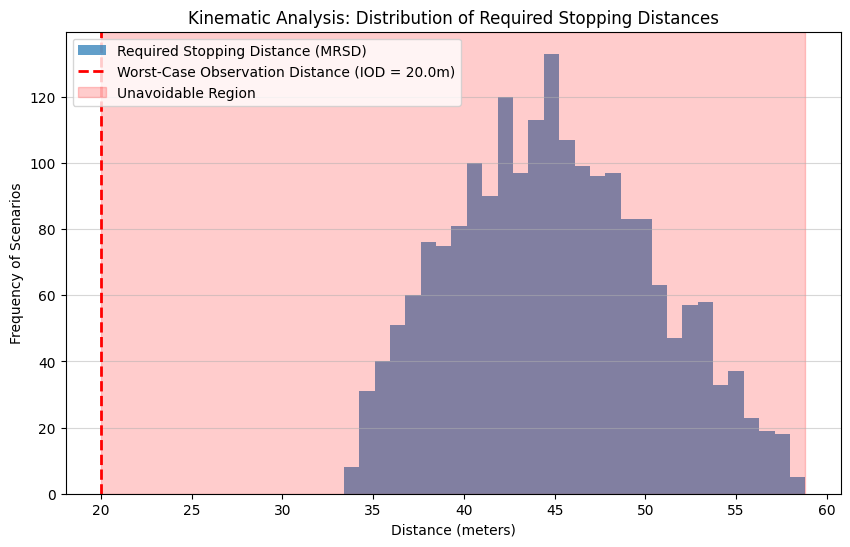

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from typing import List, Tuple


def calculate_visibility_probability() -> float:
    road_width = 10
    building_offset = 2

    corner_x = road_width / 2 + building_offset
    corner_y = -(road_width / 2 + building_offset)
    t = np.linspace(0, np.pi/2, 100)
    turn_center_x = corner_x + 2
    turn_center_y = corner_y - 2
    turn_radius = 6

    car_x_path = turn_center_x - turn_radius * np.cos(t)
    car_y_path = turn_center_y + turn_radius * np.sin(t)

    bus_stop_start_x = corner_x + 15
    bus_stop_end_x = corner_x + 35
    bus_y = -(road_width / 1.5)

    bus_positions_x = np.linspace(bus_stop_start_x, bus_stop_end_x, 50) # 50 bus positions

    visible_count = 0

    for cx, cy in zip(car_x_path, car_y_path):
        for bx in bus_positions_x:
            by = bus_y
            blocked = False

            if cx < corner_x < bx:
                slope = (by - cy) / (bx - cx)
                y_at_corner_x = cy + slope * (corner_x - cx)
                if y_at_corner_x < corner_y:
                    blocked = True

            if cy > corner_y and by < corner_y:
                if np.isclose(bx, cx): continue
                slope_inv = (bx - cx) / (by - cy)
                x_at_corner_y = cx + slope_inv * (corner_y - cy)
                if x_at_corner_y < corner_x:
                    blocked = True

            if not blocked:
                visible_count += 1

    total_scenarios = len(car_x_path) * len(bus_positions_x)
    return (visible_count / total_scenarios)

def calculate_mrsd(v: float, t_r: np.ndarray, a: np.ndarray) -> np.ndarray:

    reaction_distance = v * t_r
    braking_distance = (v**2) / (2 * a)
    return reaction_distance + braking_distance

def run_kinematic_montecarlo(num_scenarios: int) -> Tuple[np.ndarray, float]:
    T_R_SAMPLES = np.random.uniform(0.7, 1.5, size=num_scenarios)
    A_SAMPLES = np.random.uniform(3.0, 5.0, size=num_scenarios)

    MRSD_RESULTS = calculate_mrsd(CAR_SPEED_V, T_R_SAMPLES, A_SAMPLES)

    WORST_CASE_IOD = 20.0

    return MRSD_RESULTS, WORST_CASE_IOD


def synthesize_forensic_results():

    NUM_SCENARIOS = 2000

    mrsd_results, worst_case_iod = run_kinematic_montecarlo(NUM_SCENARIOS)


    IOD_ARRAY = np.full(NUM_SCENARIOS, worst_case_iod)

    feasible_scenarios = IOD_ARRAY >= mrsd_results

    total_feasible = np.sum(feasible_scenarios)
    percentage_avoidable = (total_feasible / NUM_SCENARIOS) * 100

    print("\n--- Forensic Monte Carlo Analysis (Python) ---")
    print(f"Total Monte Carlo Runs (Kinematic): {NUM_SCENARIOS}")
    print(f"--- SPATIAL INPUT ---")
    print(f"Worst-Case Initial Observation Distance (IOD): {worst_case_iod:.2f} meters")
    print(f"--- KINEMATIC RESULTS ---")
    print(f"MRSD Range: {mrsd_results.min():.2f}m (Best Case) to {mrsd_results.max():.2f}m (Worst Case)")
    print(f"Mean Required Stopping Distance: {mrsd_results.mean():.2f} meters")
    print(f"--- CONCLUSION ---")
    print(f"Scenarios where Stopping Was Possible (IOD >= MRSD): {total_feasible} / {NUM_SCENARIOS}")
    print(f"Final Avoidability Probability: {percentage_avoidable:.2f}%")

    plt.figure(figsize=(10, 6))
    plt.hist(mrsd_results, bins=30, color='#1f77b4', alpha=0.7, label='Required Stopping Distance (MRSD)')

    plt.axvline(x=worst_case_iod, color='r', linestyle='--', linewidth=2,
                label=f'Worst-Case Observation Distance (IOD = {worst_case_iod:.1f}m)')

    plt.axvspan(worst_case_iod, mrsd_results.max(), color='red', alpha=0.2, label='Unavoidable Region')

    plt.title('Kinematic Analysis: Distribution of Required Stopping Distances')
    plt.xlabel('Distance (meters)')
    plt.ylabel('Frequency of Scenarios')
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.savefig('forensic_mrsd_distribution.png')
    plt.show()

if __name__ == "__main__":

    synthesize_forensic_results()